### CIS 053: Machine Learning - Final Project
### By: Cherry Withers
### Date: May 18, 2023

### Executive Summary
 
In this project, I will test a few classification models and choose the best one to answer the following question: *“what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).--Kaggle* 

This report will include an initial EDA (Exploratory Data Analysis) of the training data and data clean-up (ie: dropping columns that may not help with the models, changing some feature values to numerical, filling in missing data using the median, etc.). 

The classification models that I will be testing are the following: 

* Decision Tree Classifier
* Random Forest Classifier
* Gaussian Naive Bayes
* K Neighbors Classifier
* Linear Support Vector Classifier
* AdaBoost
* Logistic Regression
* Perceptron

Initial use of the models will be limited to their default values and their initial comparison will be done based on their training "score"  as well as the application of cross-validation of all the models to pick the best one. Their classification report will also be compared 

After which, the best model from above will be hyperparameterized using GridSearchCV. Feature importance will also be calculated using either regularization or ranking the model's absolute coefficient magnitude. 

__What will not be included in this project__

Although the question of whether cabin location matters is an interesting one, the number of NAs for this feature is too large for both the training and test datasets. There are only 296 values that are not null to play with. A separate report on the use of this feature for creating a model might be warranted later. 

Lastly, from the following site, we can see that some of our passengers are titled individuals (Lord, Lady, Major, Colonel, Doctor, etc.): https://www.lva.virginia.gov/exhibits/titanic/passengers.php  It would be interesting to find out if this also affects who got to go on the lifeboats and survive. But that will also have to be for another project and time.  

In summary, feature engineering will not be included nor will ensemble techniques to fine-tune the model. 

### Introduction/Background


 > The sinking of the Titanic is one of the most infamous shipwrecks in history.
 > On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.
 > While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.
 -- Kaggle: https://www.kaggle.com/c/titanic

This project was introduced as a competition at Kaggle.com The data is split into two datasets: train.csv (which includes 891 rows and 12 columns) and test.csv (which has 418 rows and 11 columns). The test dataset does not include the "ground truth" outcome and only serves as the "unseen" data. We will primarily use the training data set in our evaluations. The following are the features: 
* pclass - indicates socio-economic status (1 - upper class, 2 - middle, 3 - lower)
* age - age is fractional if less than 1 
* sibsp - # of siblings/spouses aboard
* parch - # of parents/children aboard
* ticket - ticket #
* fare - cost of the ticket/passenger
* cabin - cabin number (the letter indicate the part/floor where cabin is located)
* embarked - port of embarkation (C-Cherbourg, Q-Queenstown, S-Southampton)

Our output is the "Survived" column, which indicates whether the passenger survives-1 or not-0.
 
**Note: Approach and Methodology, along with results (plots, tables, observations, etc) are below. Conclusions, Survey and References will follow, respectively**


### Approach and Methodology


__Importing the Modules__

In [421]:
import warnings
warnings.filterwarnings("ignore")

# Compare Algorithms
import pandas as pd
import numpy as np
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

# Modules for Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Modules for Pre-processing
from sklearn.preprocessing import StandardScaler

# Modules for models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

__Reading in the datasets__

In [422]:
# Read in the training and testing datasets
train_df = pd.read_csv("datasets/train.csv")
test_df = pd.read_csv("datasets/test.csv")

# Print some basic information about the training data
print("Column names: ", train_df.columns)
print("\nTrain Data Info: ", train_df.info())

# Sneak peak at what the dataset looks like
train_df.head()

Column names:  Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Train Data Info:  None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [423]:
print(test_df.shape)

test_df.isnull().sum()

(418, 11)


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

__Training Dataset Clean-up__

From the above, we can see that the column "Cabin" has 77% missing values in the training set and 78% in the test dataset. Because of the high NA value, I will drop this column. Also, I don't think it will add to the model at this time. Further exploration of cabin locations vs survival may be warranted in the future. I will also drop the columns "PassengerID", "Ticket" number, and "Name" because they are unique identifiers and will not add to our model. The columns "Sex" and "Embarked" will be changed into numerical categorical values. "Fare" and "Age" NAs will be filled with median values and will also be converted into integers.

In [424]:
# Drop columns on both train and test datasets
train_df = train_df.drop(['Cabin', 'PassengerId', 'Ticket', 'Name'], axis=1)
test_df = test_df.drop(['Cabin', 'PassengerId', 'Ticket', 'Name'], axis=1)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [425]:
# Change Sex column to numerical values 
genders = {"male": 0, "female": 1}
train_df['Sex'] = train_df['Sex'].map(genders)
test_df['Sex'] = test_df['Sex'].map(genders)

# Drop Embarked NAs
train_df = train_df.dropna(subset=['Embarked'])
test_df = test_df.dropna(subset=['Embarked'])

# Change Embarked to numerical values
ports = {"S": 0, "C": 1, "Q": 2}
train_df['Embarked'] = train_df['Embarked'].map(ports).astype(int)
test_df['Embarked'] = test_df['Embarked'].map(ports).astype(int)

# Filling missing Age values using the median
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)

# Change Fare and Age to int
train_df['Age'] = train_df['Age'].astype(int)
test_df['Age'] = test_df['Age'].astype(int)

# Filling in missing Fare values using the median
train_df['Fare'].fillna(train_df['Fare'].median(), inplace=True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

train_df['Fare'] = train_df['Fare'].astype(int)
test_df['Fare'] = test_df['Fare'].astype(int)

# Reorder the columns
train_df = train_df[['Embarked', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']]
test_df = test_df[['Embarked', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]

In [426]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Embarked  889 non-null    int32
 1   Pclass    889 non-null    int64
 2   Sex       889 non-null    int64
 3   Age       889 non-null    int32
 4   SibSp     889 non-null    int64
 5   Parch     889 non-null    int64
 6   Fare      889 non-null    int32
 7   Survived  889 non-null    int64
dtypes: int32(3), int64(5)
memory usage: 52.1 KB


In [427]:
train_df.head()

,Embarked,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
0,0,3,0,22,1,0,7,0
1,1,1,1,38,1,0,71,1
2,0,3,1,26,0,0,7,1
3,0,1,1,35,1,0,53,1
4,0,3,0,35,0,0,8,0


### Exploratory Data Analysis

In [428]:
train_df.describe()

,Embarked,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.362205,2.311586,0.350956,29.299213,0.524184,0.382452,31.677165,0.382452
std,0.636157,0.834700,0.477538,12.993433,1.103705,0.806761,49.706915,0.486260
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.000000,0.000000
50%,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.000000,0.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,2.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.000000,1.000000


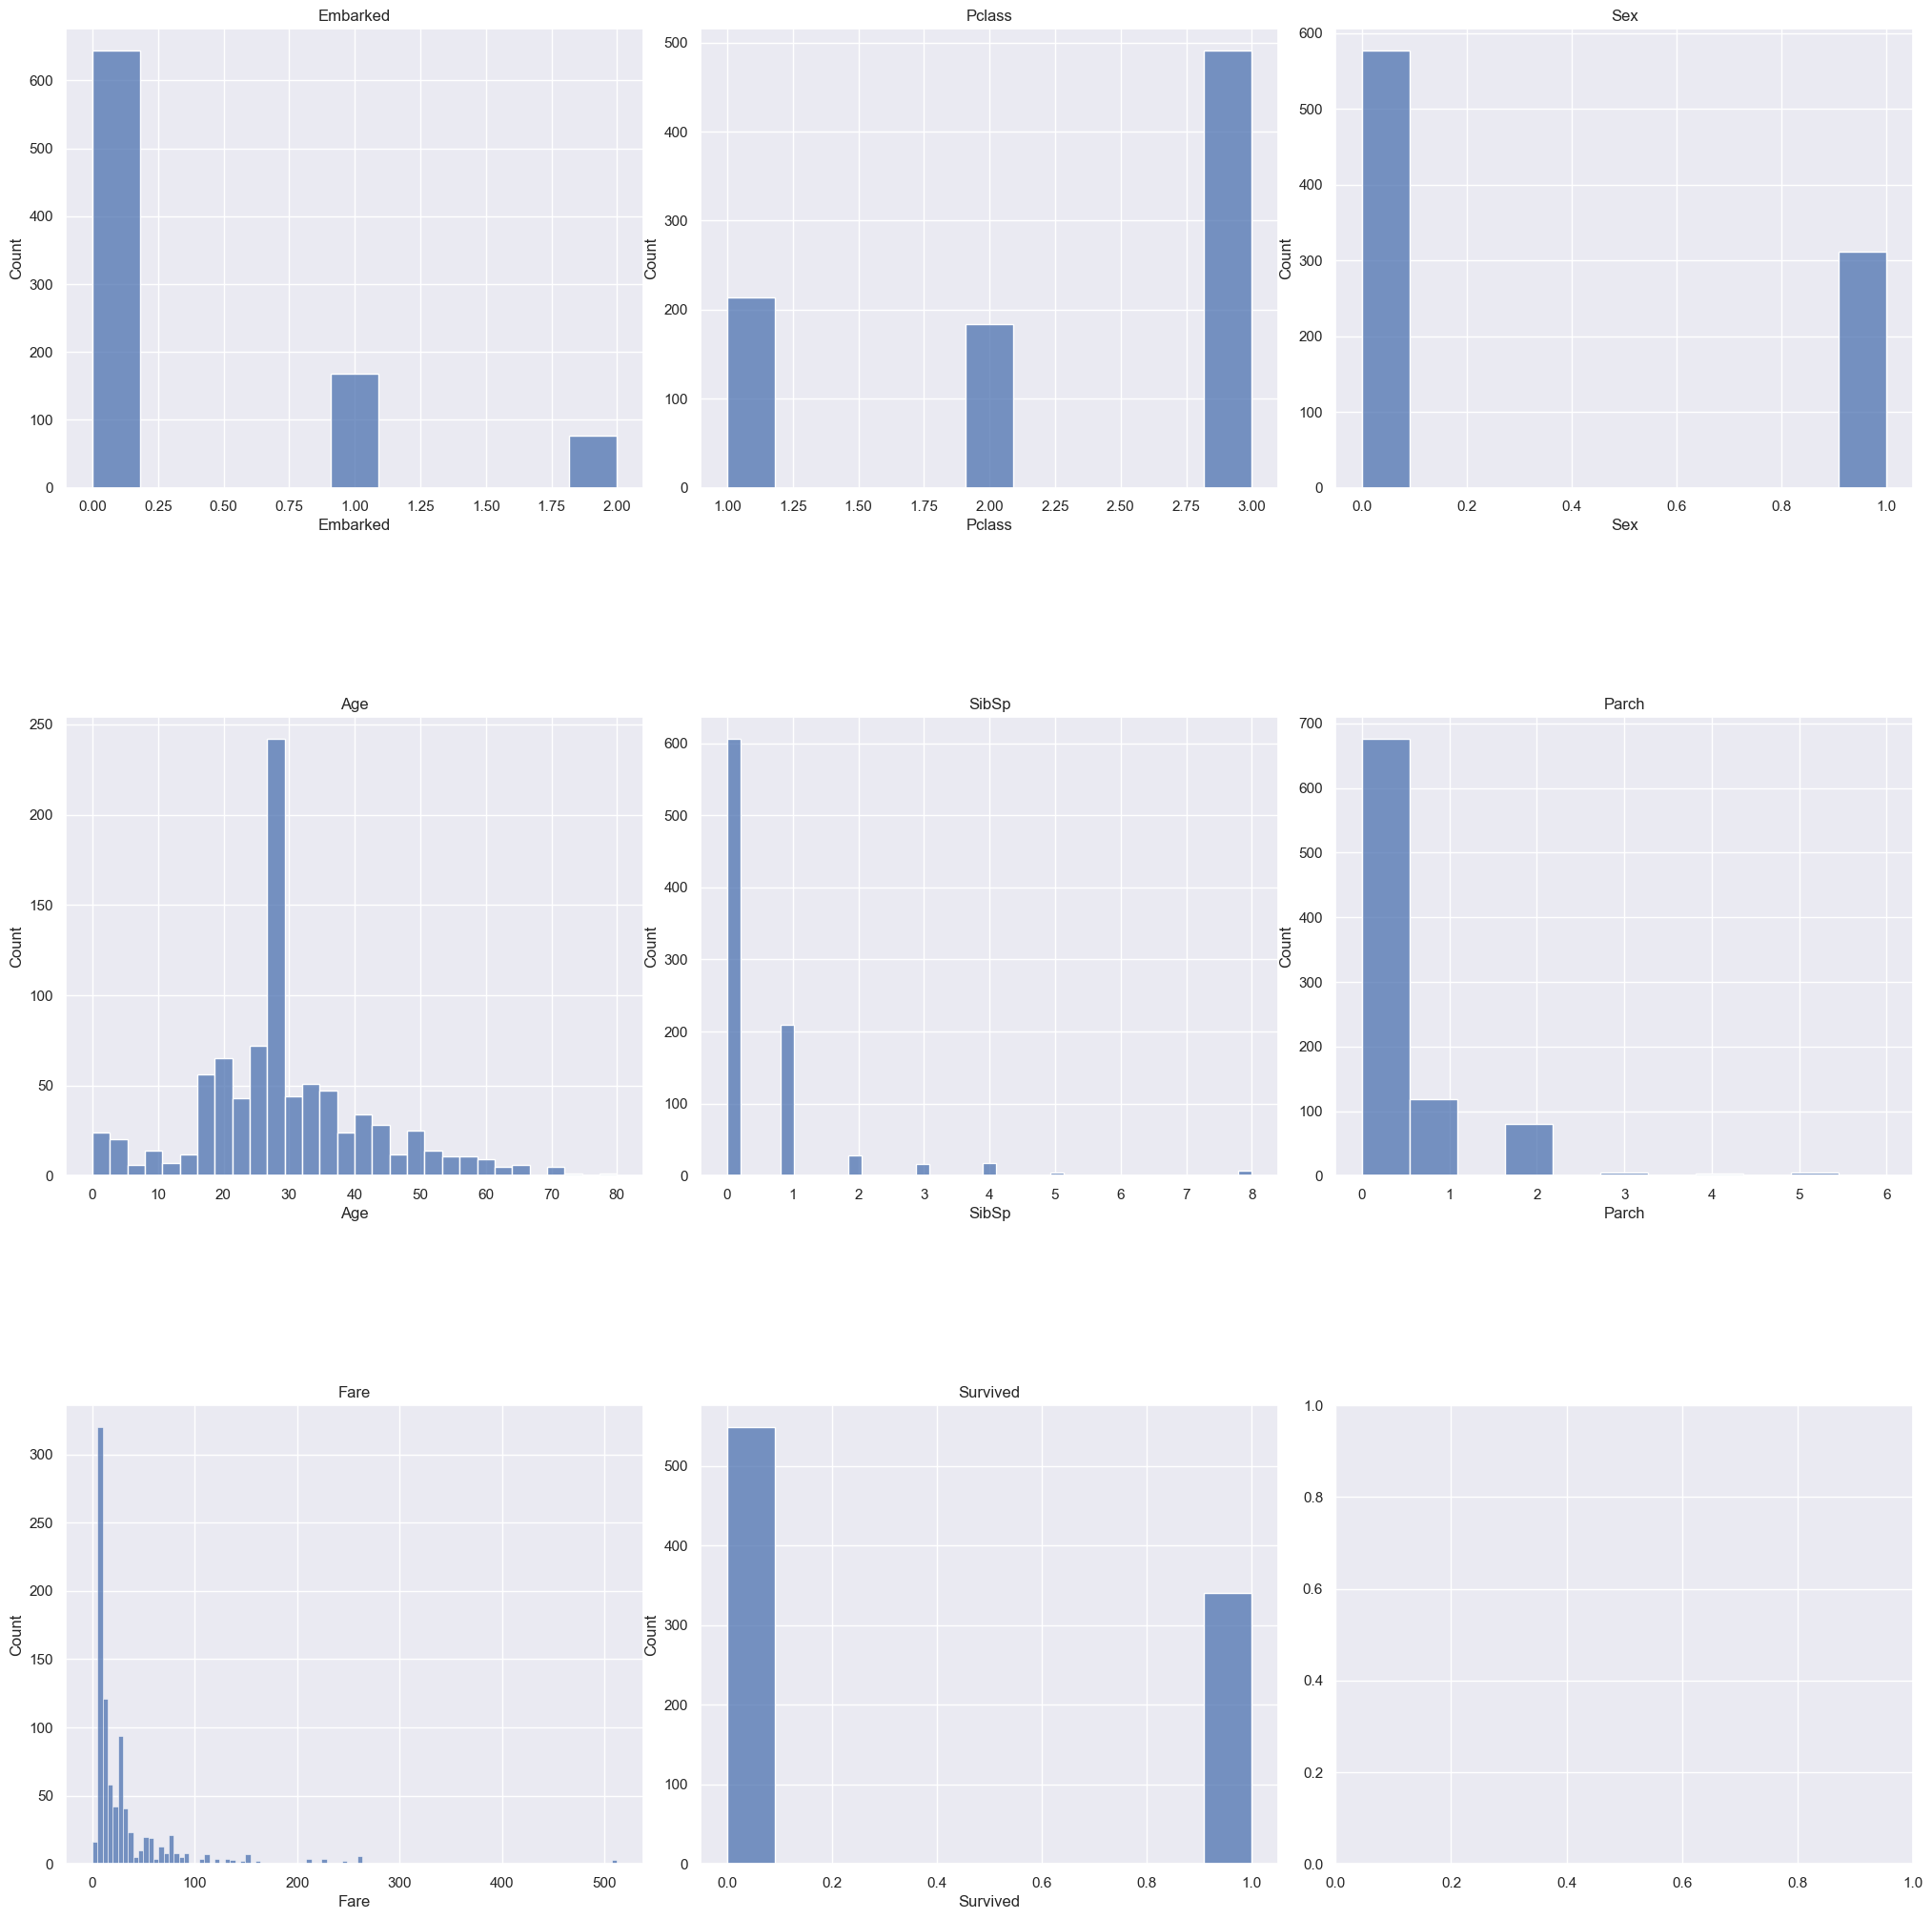

In [429]:
# Plotting the histograms

def plot_histograms(data):
    # Create a 5x4 grid of subplots with a shared x-axis and y-axis
    fig, axes = plt.subplots(3, 3, figsize=(25, 25))

    # Flatten the axes array to make it easier to iterate through
    axes = axes.flatten()

    # Looping through each column and plot its distribution using histplot
    for i, col in enumerate(data.columns):
        sns.histplot(data=data, x=col, kde=False, ax=axes[i])
        axes[i].set_title(col)

    # Adjusting the spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.5)

    # Show the plot
    plt.show()

# histograms of pre-processed data
plot_histograms(train_df)

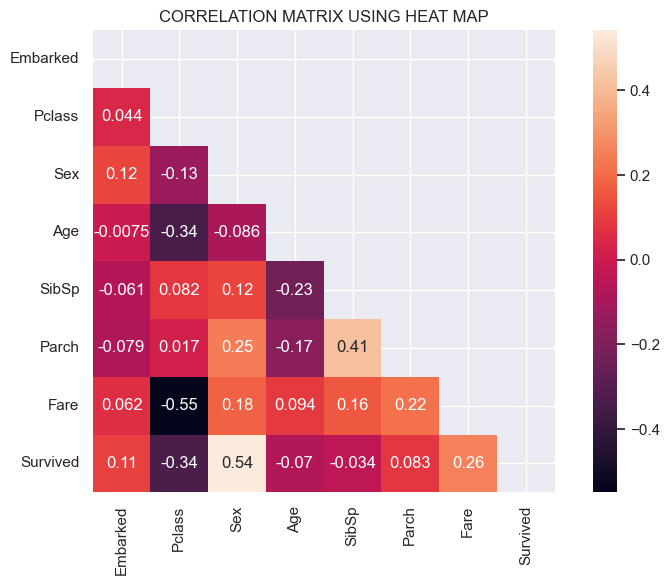

In [430]:
train_preprocessed = train_df.copy()
train_preprocessed = train_preprocessed.corr(method="pearson")

# Plot the correlation heatmap.  
mask = np.triu(np.ones_like(train_preprocessed, dtype=bool)) # mask the upper triangle
sns.set(rc = {'figure.figsize':(10,6)})
sns.heatmap(train_preprocessed, annot=True, square=True, mask = mask)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title("CORRELATION MATRIX USING HEAT MAP")
plt.show()

__Observations__

Based on the initial descriptive statistics, it appears that I may need to do some Standardization because some of the features like Age and Fare are in several orders of magnitude compared to other features like SibSp and Parch. 

The correlation/heatmap above indicates that most of the features are independent of each other and have low to no correlation except for Pclass and Fare, which interestingly enough have a mild negative correlation. The strongest correlation with the output (Survived) is with the feature Sex with the rest of the features having weak to no correlation at all. 

### Data Transformations and Processing

In this section, I divided the data set into features and output. I also used StandardScaler to fix the scaling issues of the features. Another quick look at the descriptive statistics and distribution will also be provided. 

In [432]:
# Separating our features and output
X_train = train_df.drop('Survived', axis=1)
y_train = train_df['Survived']

X_test = test_df

In [433]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

# you can make a new data frame with the standardized data
dataStandDf = pd.DataFrame(rescaledX, columns = X_train.columns)

# show descriptive stats after standardization
descriptionStand = dataStandDf.describe()

descriptionStand

,Embarked,Pclass,Sex,Age,SibSp,Parch,Fare
count,8.890000e+02,8.890000e+02,8.890000e+02,8.890000e+02,8.890000e+02,8.890000e+02,8.890000e+02
mean,-1.138946e-16,-2.437745e-16,-4.395934e-17,3.996303e-17,-3.197043e-17,-4.795564e-17,2.197967e-17
std,1.000563e+00,1.000563e+00,1.000563e+00,1.000563e+00,1.000563e+00,1.000563e+00,1.000563e+00
min,-5.696840e-01,-1.572211e+00,-7.353420e-01,-2.256194e+00,-4.751991e-01,-4.743259e-01,-6.376376e-01
25%,-5.696840e-01,-3.735013e-01,-7.353420e-01,-5.620779e-01,-4.751991e-01,-4.743259e-01,-4.967328e-01
50%,-5.696840e-01,8.252086e-01,-7.353420e-01,-1.000462e-01,-4.751991e-01,-4.743259e-01,-3.558281e-01
75%,1.003139e+00,8.252086e-01,1.359911e+00,4.389907e-01,4.313502e-01,-4.743259e-01,-1.363083e-02
max,2.575963e+00,8.252086e-01,1.359911e+00,3.904228e+00,6.777195e+00,6.967010e+00,9.668538e+00


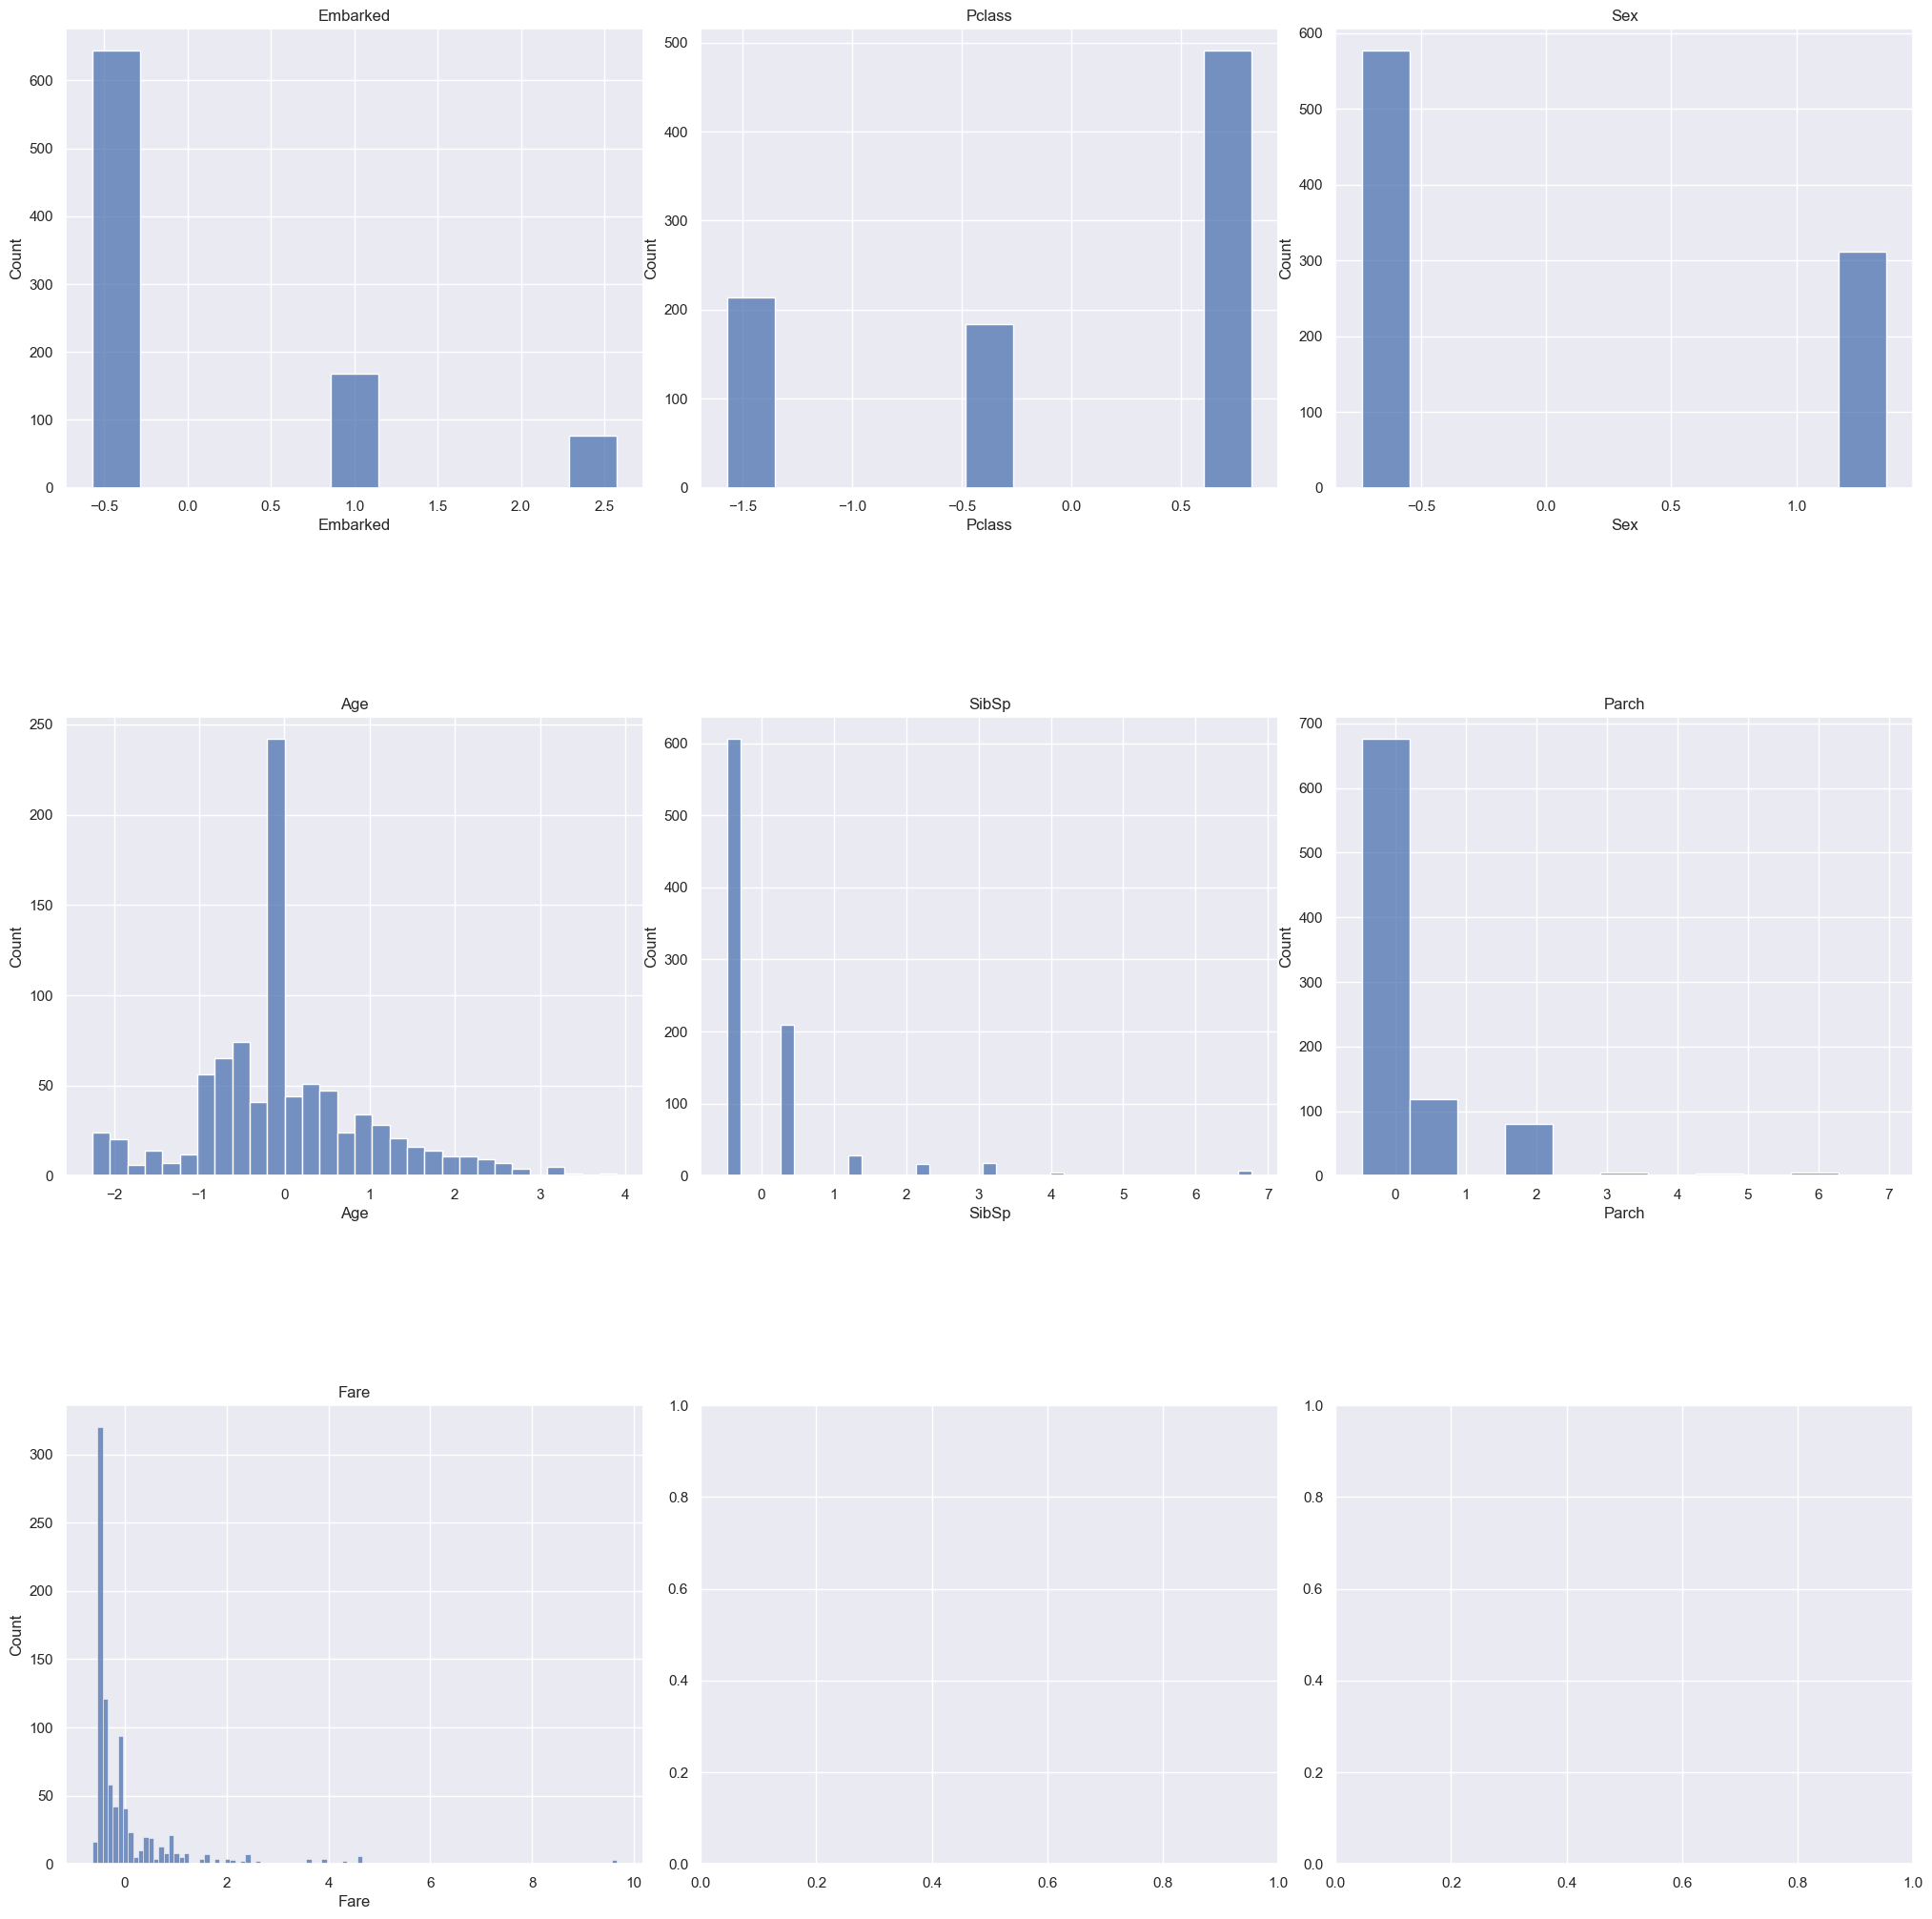

In [434]:
plot_histograms(dataStandDf)

In [435]:
X_train = rescaledX

### Building Machine Learning Models

The following models will be tested and compared: 
* Decision Tree Classifier
* Random Forest Classifier
* Gaussian Naive Bayes
* K Neighbors Classifier
* Linear Support Vector Classifier
* AdaBoost
* Logistic Regression
* Perceptron

In [436]:
models = [
    {'name': 'Linear SVC',
     'model': LinearSVC()},
    {'name': 'Kernel SVC',
     'model': SVC()},
    {'name': 'Random Forest',
     'model': RandomForestClassifier(n_estimators=100)},
    {'name': 'Gaussian Naive Bayes',
     'model': GaussianNB()},
    {'name': 'K Neighbors Classifier',
     'model': KNeighborsClassifier(n_neighbors = 3)},
    {'name': 'AdaBoost',
     'model': AdaBoostClassifier()},
    {'name': 'Logistic Regression',
     'model': LogisticRegression()},
    {'name': 'Perceptron',
     'model': Perceptron()}
]
# Train and evaluate each model using a loop
for model in models:
    print(model['name'])
    model['model'].fit(X_train, y_train)
    y_pred = model['model'].predict(test_df)
    train_score = model['model'].score(X_train, y_train)
    print("Score:", train_score)
    print()

Linear SVC
Score: 0.7986501687289089

Kernel SVC
Score: 0.8447694038245219

Random Forest
Score: 0.9617547806524185

Gaussian Naive Bayes
Score: 0.7907761529808774

K Neighbors Classifier
Score: 0.8695163104611924

AdaBoost
Score: 0.8267716535433071

Logistic Regression
Score: 0.8008998875140607

Perceptron
Score: 0.7694038245219348



__Observations:__

The initial scoring for the 8 models indicates that Random Forest performed well with a score of 96% while the Perceptron model scored the least at 76.9%. I will test these further by performing cross-validation amongst all of our models.

### K-fold Cross-Validation

Linear SVC: 0.791969 (0.031560)
Kernel SVC: 0.822357 (0.042670)
Random Forest: 0.804277 (0.032619)
Gaussian Naive Bayes: 0.789709 (0.039346)
K Neighbors Classifier: 0.800958 (0.025307)
AdaBoost: 0.805465 (0.041538)
Logistic Regression: 0.795378 (0.037223)
Perceptron: 0.705273 (0.061148)


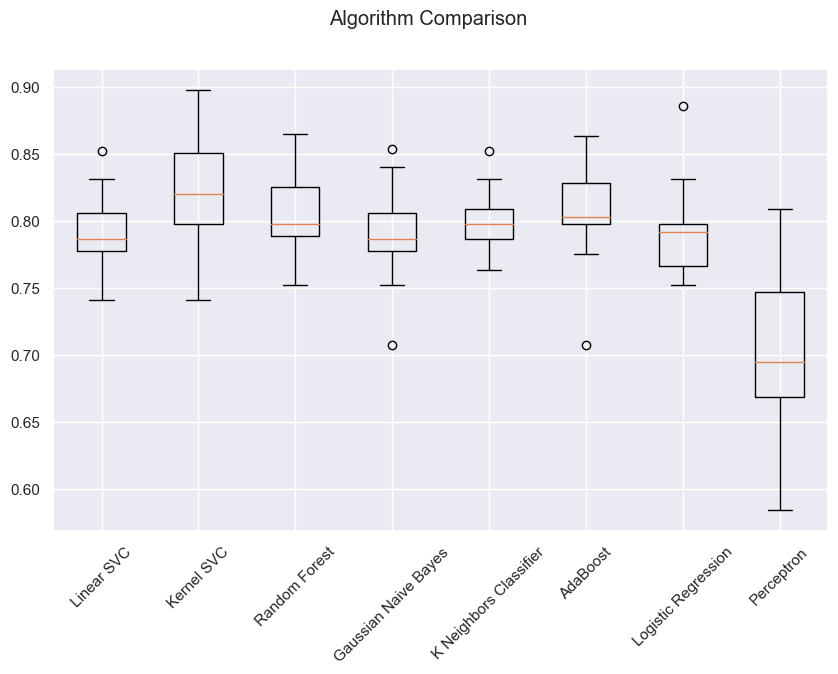

In [437]:
models = [
    {'name': 'Linear SVC',
     'model': LinearSVC()},
    {'name': 'Kernel SVC',
     'model': SVC()},
    {'name': 'Random Forest',
     'model': RandomForestClassifier(n_estimators=100)},
    {'name': 'Gaussian Naive Bayes',
     'model': GaussianNB()},
    {'name': 'K Neighbors Classifier',
     'model': KNeighborsClassifier(n_neighbors = 3)},
    {'name': 'AdaBoost',
     'model': AdaBoostClassifier()},
    {'name': 'Logistic Regression',
     'model': LogisticRegression()},
    {'name': 'Perceptron',
     'model': Perceptron()}
]

results = []
names = []
scoring = 'accuracy'

for model_dict in models:
    name = model_dict['name']
    model = model_dict['model']
    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names, rotation=45)
pyplot.show()


__Observations__

My results above show that there's a difference in which model performs the best at cross-validation vs our initial accuracy scoring. The model KernelSVC (SVC) performed the best after cross-validation (while Perceptron consistently performed poorly). While RandomForest didn't perform too badly after cross-validation, it didn't even come as a close second. Adaboost and KNNeighbors were 2nd and 3rd, respectively. 

The difference in the cross-validation result vs the initial scoring may be because the initial score only captures one case of a test-train-split while cross-validation does multiple data splits and takes the mean of the performance score. Cross-validation is a more robust and reliable means of testing our models' performance. Also, the high accuracy score of RandomForest model during the initial check may be an indication that the particular slice that was being measured was overfitted. 

I will next measure each model's Recall, Precision, and F1_score. It is important to keep in mind that I was still only using the train.csv data set. The splits will not include any test data. 


In [438]:
# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Iterate over the models
for model_info in models:
    model_name = model_info['name']
    model = model_info['model']

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Display the classification report
    print('==========================================================')
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_val, y_pred))
    print('==========================================================')

Classification Report for Linear SVC:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       109
           1       0.70      0.75      0.73        69

    accuracy                           0.78       178
   macro avg       0.77      0.78      0.77       178
weighted avg       0.78      0.78      0.78       178

Classification Report for Kernel SVC:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       109
           1       0.78      0.71      0.74        69

    accuracy                           0.81       178
   macro avg       0.80      0.79      0.80       178
weighted avg       0.81      0.81      0.81       178

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       109
           1       0.72      0.75      0.74        69

    accuracy                           0.79       178
   macro av

__Observations:__

The classification report above further supports the Kernel SVC as the best performing model 

### Kernel SVC as our Chosen Model



#### Hyperparameterize the model using GridSearchCV

In [439]:
from sklearn.model_selection import GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Create the Kernel SVC model
model = SVC()

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters: ", grid_search.best_params_)

# Make predictions on the test set using the best model
y_pred = grid_search.predict(X_val)

# Calculate and print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))


Best Hyperparameters:  {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        92
           1       0.84      0.61      0.70        51

    accuracy                           0.82       143
   macro avg       0.82      0.77      0.79       143
weighted avg       0.82      0.82      0.81       143



#### Feature Importance to our model

In [440]:
model = SVC(kernel='linear')

model.fit(X_train, y_train)

# Retrieve the coefficients
coefficients = model.coef_

# Calculate the absolute values of the coefficients
abs_coefficients = np.abs(coefficients)

# Calculate the mean or maximum coefficient values across classes
mean_coefficients = np.mean(abs_coefficients, axis=0)
max_coefficients = np.max(abs_coefficients, axis=0)   

# Sort the features based on their influence
sorted_features = np.argsort(mean_coefficients)[::-1]  # Sort in descending order

# Map feature indices to feature names
feature_names = ['Embarked', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
sorted_features_names = [feature_names[feature_index] for feature_index in sorted_features]

# Printing the features and their corresponding influences
print("Features in order of their influence on our model :")
print("---------------------------------------------------")
for feature_name, feature_index in zip(sorted_features_names, sorted_features):
    print(f"{feature_name} ({feature_index}): {mean_coefficients[feature_index]}")

Features in order of their influence on our model :
---------------------------------------------------
Sex (2): 0.9879481196789639
Pclass (1): 0.24356455357787732
Age (3): 0.229571269390489
SibSp (4): 0.21576995892023604
Parch (5): 0.18002252090705628
Fare (6): 0.09410735563074721
Embarked (0): 0.05138412257467817


Text(0.5, 1.0, 'Survival Rate by Sex')

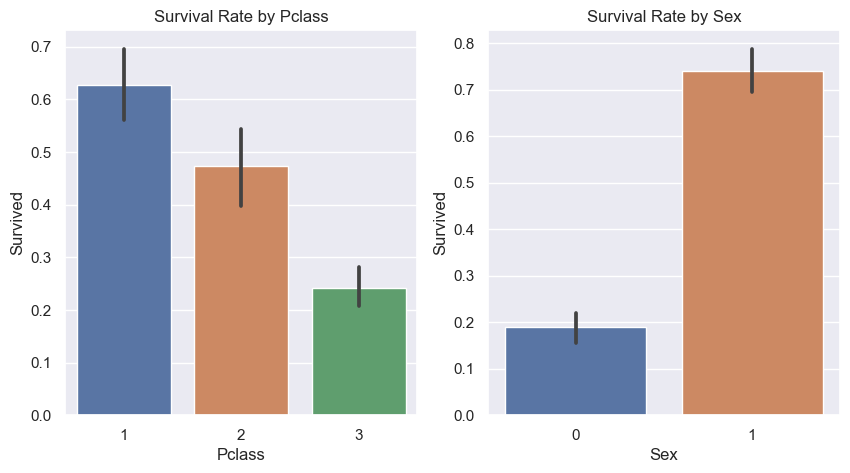

In [445]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(x='Pclass', y='Survived', data=train_df, ax=axes[0])
axes[0].set_title('Survival Rate by Pclass')

sns.barplot(x='Sex', y='Survived', data=train_df, ax=axes[1])
axes[1].set_title('Survival Rate by Sex')


### Conclusions

I have tested 8 different classification models with their default parameters for this project. Out of those 8, Kernel SVC (or SVC) proved to be the best and outperformed the rest of them during cross-validation. Further fine-tuning of this model using hyper parameterization resulted in a very minimal improvement. Sorting out the magnitude of our model's absolute coefficient resulted in Sex being the feature with the most influence on the model. The socio-economic class of the passenger Pclass came in as a distant second. The graphs above indicate that female passengers belonging to the upper class fared a whole lot better than male passengers who belong to the lower class. 

"Titanic" Wikipedia supports the conclusion above. There were more upper-class male passengers (175) vs upper-class female passengers (144). And yet, 97% of these upper-class women survived vs only 33% of their male counterparts. The table also shows that it doesn't matter which socio-economic class the female passenger belongs to. Their survival rates are greatly different than their male counterparts: Second-class females 86% vs 8% for males, Third-class females 46% vs 16%, Female crew 87% vs 22%. **Chivalry was not dead during those times. Leonardo diCaprio can attest to that.** 

A caveat to the conclusion above is that I didn't train our model using the complete data set. The results may be different if I included the test data. 


### Survey of what others have done


I didn't want to get bogged down with other people's approaches so I only did a cursory glance at a few of them (unfortunately, not making note of which ones I've looked at). Some people limited themselves to less than a handful of models for their initial comparisons, but I wanted to "widen the net" by testing 8 of the applicable classification models. 

Another thing that I noticed was how people differed in their approach to the missing data, especially for the Age feature. Some used randomized values, some did imputation using Logistic Regression, some just outright dropped the NAs, and others like myself stuck to using the median value. 

One thing that I wish I had time to do was feature engineering. Some used the passenger's titles to figure out if their chances of survival are greater if they are from nobility or military background vs that of a regular person. I also saw one entry that explored the cabin location and further broke down this column into the deck location and room location. This allowed them to see if the cabin location has any bearing on the passenger's survival. 

### References

Kaggle: https://www.kaggle.com/c/titanic

"Predicting the Survival of Titanic Passengers" (for general format): https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8#:~:text=sibsp%3A%20%23%20of%20siblings%20%2F%20spouses,fare%3A%20Passenger%20fare

"Titanic in Black and White": https://www.lva.virginia.gov/exhibits/titanic/passengers.php

"Titanic" Wikipedia: https://en.wikipedia.org/wiki/Titanic
